We plot the normalization curve as for a given sample of the recurrent weight matrix W_r.

In [6]:
import torch
import os
import json
import re
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import perturbed_organics.model.ORGaNICs_models as organics
from perturbed_organics.spectrum_general import sim_solution
import matplotlib.cm as cm
import matplotlib.colors as colors
import importlib.util
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
import perturbed_organics.utils as utils

torch.set_default_dtype(torch.float64)

plt.rcParams.update({
    "text.usetex": False, 
    "font.family": "serif", 
    "font.serif": ["Computer Modern Roman", "DejaVu Serif", "Bitstream Vera Serif"],
    "mathtext.fontset": "cm" 
})

In [7]:
# Define simulation parameters
N = 10
params = {"N_y": N, "N_a": N, "eta": 0.02, "noise_type": "additive"}
b0 = torch.ones(N)
b1 = torch.ones(N)
sigma = torch.tensor([0.1])
tauA = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
tauY = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
# Wyy = torch.eye(N)
Way = torch.ones(N, N)

In [15]:
# Specify delta and generate Wyy
mu = 0.0
delta = 0.05

In [16]:
# Define the time vector for simulation
tau_min = min(torch.min(tauA), torch.min(tauY))
tau_max = max(torch.max(tauA), torch.max(tauY))
chunk_time = 100 * tau_max
dt = 0.05 * tau_min
points = int(chunk_time / dt)
t_chunk = torch.linspace(0, chunk_time, points)

In [21]:
# Model setup
model_name = 'delocalized'
input_norms = torch.logspace(-2, 0, 10)
initial_type = 'zero'

num_trials = 10

steady_states = torch.zeros(num_trials, len(input_norms), 2 * N)

In [22]:
for trial in range(num_trials):
    Wyy = torch.eye(N) + utils.generate_matrix(N=N, matrix_type='goe_symmetric', s=N, mu=mu, delta=delta)
    for i in range(len(input_norms)):
        z = utils.make_input_drive(N=N, input_type=model_name, input_norm=float(input_norms[i]))
        model = organics.ORGaNICs2Dgeneral(
            params=params,
            b0=b0,
            b1=b1,
            sigma=sigma,
            tauA=tauA,
            tauY=tauY,
            Wyy=Wyy,
            Way=Way,
            z=z,
            initial_type=initial_type,
            run_jacobian=False,
        )
        sim_obj = sim_solution(model)
        y0 = model.inital_conditions(initial_type=initial_type)
        steady_states[trial, i] = sim_obj.steady_state(time=chunk_time, points=points, y0=y0)

In [23]:
idx = 0
input_range = input_norms

norm_sol_idx = []
for input_norm in input_range:
    z = utils.make_input_drive(N=N, input_type=model_name, input_norm=input_norm)
    norm_eqn = torch.sqrt(z ** 2 / (sigma ** 2 + torch.norm(z) ** 2))
    norm_sol_idx.append(norm_eqn[idx].item())
norm_sol_idx = np.array(norm_sol_idx)
analytical_mean = norm_sol_idx

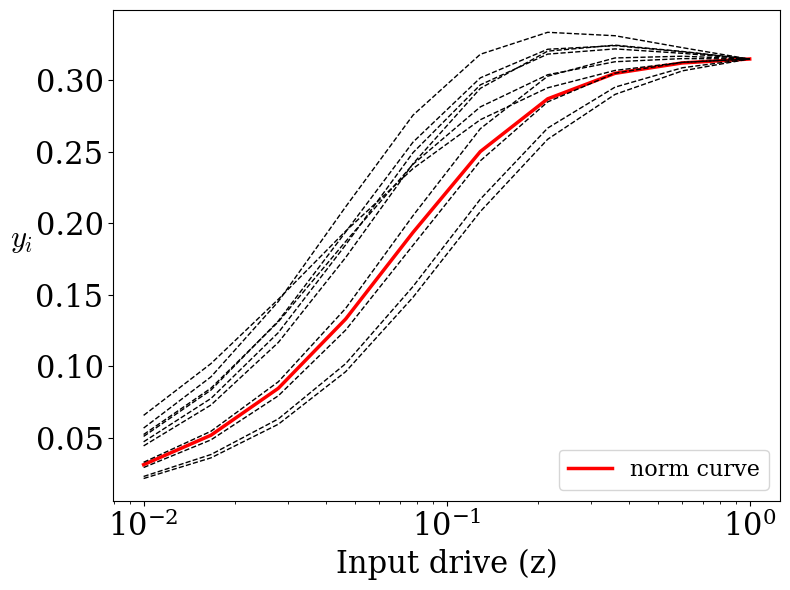

In [27]:
plt.figure(figsize=(8, 6))

# plot the norm curve
plot = plt.plot(input_norms, analytical_mean, label=f"norm curve", color='red', linewidth=2.5)

for trial in range(num_trials):
    plt.plot(input_norms, steady_states[trial, :, idx], color='black', linestyle='--', linewidth=1.0)

# make the x axis logscale
plt.xlabel('Input drive (z)', fontsize=22)
plt.ylabel(r"$y_i$", fontsize=22, rotation=0, labelpad=10)
plt.xscale('log')
plt.legend(fontsize=16, loc='lower right')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()

# folder_loc = f'../figures/mu_{mu}/fig2'
# os.makedirs(folder_loc, exist_ok=True)
# file_name = f'{input_type}_{delta_val}'
# file_save_path = os.path.join(folder_loc, file_name)

# plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
# plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()